# Finetuning

Create custom dataset + finetune a bert model on it

## Structure

- `drive/MyDrive/Colab Notebooks/nlp2/NLPA-main.zip` is the zipped repo

---

In [ ]:
# ![ -e "staqc_man_python_codegen.hf" ] || unzip drive/MyDrive/"Colab Notebooks/nlp2"/staqc*config*.zip > /dev/null
# ![ -e "staqc_man_python_codegen.hf" ] || unzip drive/MyDrive/"Colab Notebooks/nlp2"/staqc*.zip > /dev/null
# !unzip drive/MyDrive/"Colab Notebooks/nlp2"/staqc_man_python_codegen.hf.zip > /dev/null
# !unzip drive/MyDrive/"Colab Notebooks/nlp2"/staqc_man_python_codegen_comments.hf.zip > /dev/null
# !unzip drive/MyDrive/"Colab Notebooks/nlp2"/staqc_man_python_codegen_source.hf.zip > /dev/null
# !unzip !unzip final.zipstaqc*.zip > /dev/null
# !unzip drive/MyDrive/"Colab Notebooks/nlp2"/final.zip > /dev/null
!cp drive/MyDrive/"Colab Notebooks/nlp2"/dataset.parquet .

---

In [ ]:
!pip install datasets 'transformers[torch]' evaluate accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00


---

In [ ]:
!rm -rf saved_model training.zip test_trainer

In [ ]:
from datasets import load_dataset, concatenate_datasets, load_from_disk, DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainerCallback
import matplotlib.pyplot as plt

In [ ]:
train_test_split = .1
label_human = 0
label_generated = 1



# def preprocess_dataset(dataset):
#     return dataset.sort('question_id').map(convert_item, remove_columns=['snippet']).shuffle(42618)


def split_dataset(dataset):
    n = len(dataset['train'])
    splitsep = int(n * train_test_split)

    dataset['test'] = dataset['train'].select(range(splitsep))
    dataset['train'] = dataset['train'].select(range(splitsep, n))

    return dataset


data = load_dataset('parquet', data_files='dataset.parquet')['train'].shuffle(42)
# data = load_from_disk('final').shuffle(42)
dataset = {'text': [], 'label': []}
for d in data:
    dataset['text'].append(d['code'])
    dataset['label'].append(label_human)
    dataset['text'].append(d['generated_code'])
    dataset['label'].append(label_generated)

dataset = Dataset.from_dict(dataset)

print(len(dataset))
dataset = DatasetDict({"train": dataset})
dataset = split_dataset(dataset)

3976


In [ ]:
# dataset = load_from_disk('staqc_man_python_codegen.hf')
# dataset = load_from_disk('staqc_man_python_codegen_source.hf')
# dataset = load_from_disk('staqc_man_python_codegen_comments.hf')
# dataset = load_from_disk('staqc_man_python_codegen_all_configs.hf')
print(dataset)
print(dataset['train'][0]['text'])

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3579
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 397
    })
})
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd

# Define the lists X and y
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
y = np.dot(X, np.array([1, 2]))

# Calculate the difference between the current value in X and the index of the current element
diff = X[:, 0] - np.arange(X.shape[0])

# Calculate the decrease per step in the values of y
decrease_per_step = np.mean(diff / y)

# Calculate the total number of restaurants in a particular range
total_restaurants = int(np.sum(y) / decrease_per_step)

# Print the total number of restaurants in Tripadvisor
print(total_restaurants)


In [ ]:
# TODO : Change tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# small_train_dataset = dataset["train"].shuffle(seed=42).select(range(500)).map(tokenize_function, batched=True)
small_train_dataset = dataset["train"].shuffle(seed=42).map(tokenize_function, batched=True)
# small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(100)).map(tokenize_function, batched=True)
small_eval_dataset = dataset["test"].shuffle(seed=42).map(tokenize_function, batched=True)

# small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000)).map(tokenize_function, batched=True)
# small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(1000)).map(tokenize_function, batched=True)

Map:   0%|          | 0/3579 [00:00<?, ? examples/s]

Map:   0%|          | 0/397 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

batch_size = 16
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", per_device_train_batch_size=batch_size,)

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
train_history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.382126,0.826196
2,No log,0.336800,0.858942
3,0.414600,0.345735,0.876574


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


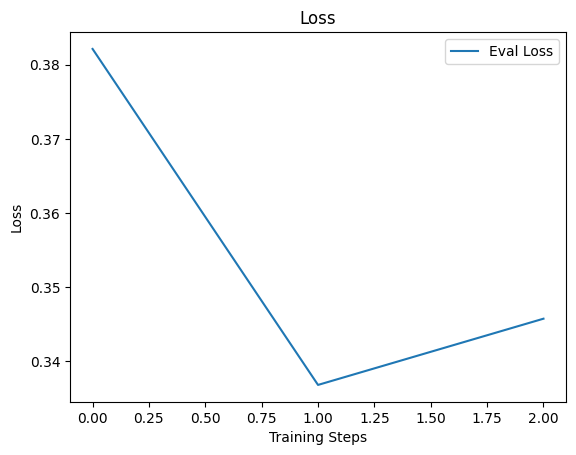

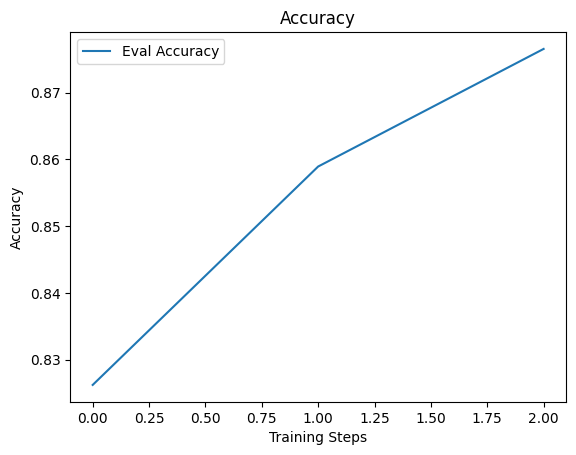

In [ ]:
eval_losses = []
for log in trainer.state.log_history:
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

eval_accuracies = []
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        eval_accuracies.append(log['eval_accuracy'])

plt.title("Loss")
plt.plot(eval_losses, label="Eval Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Accuracy")
plt.plot(eval_accuracies, label="Eval Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Save everything
model.save_pretrained("./saved_model")
trainer.save_model("./saved_model/trainer")
tokenizer.save_pretrained("./saved_model")
!rm -f training.zip && zip -r training.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/vocab.txt (deflated 49%)
  adding: saved_model/model.safetensors (deflated 7%)
  adding: saved_model/tokenizer.json (deflated 70%)
  adding: saved_model/vocab.json (deflated 59%)
  adding: saved_model/trainer/ (stored 0%)
  adding: saved_model/trainer/training_args.bin (deflated 52%)
  adding: saved_model/trainer/model.safetensors (deflated 7%)
  adding: saved_model/trainer/config.json (deflated 49%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/config.json (deflated 49%)
  adding: saved_model/merges.txt (deflated 53%)
  adding: saved_model/tokenizer_config.json (deflated 76%)


In [ ]:
!ls -lh training.zip

-rw-r--r-- 1 root root 768M Mar  1 19:53 training.zip
